# Tree-Based Methods – Conceptual

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Draw an example (of your own invention) of a partition of two-dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions R1, R2, . . ., the cutpoints t1,t2,..., and so forth.

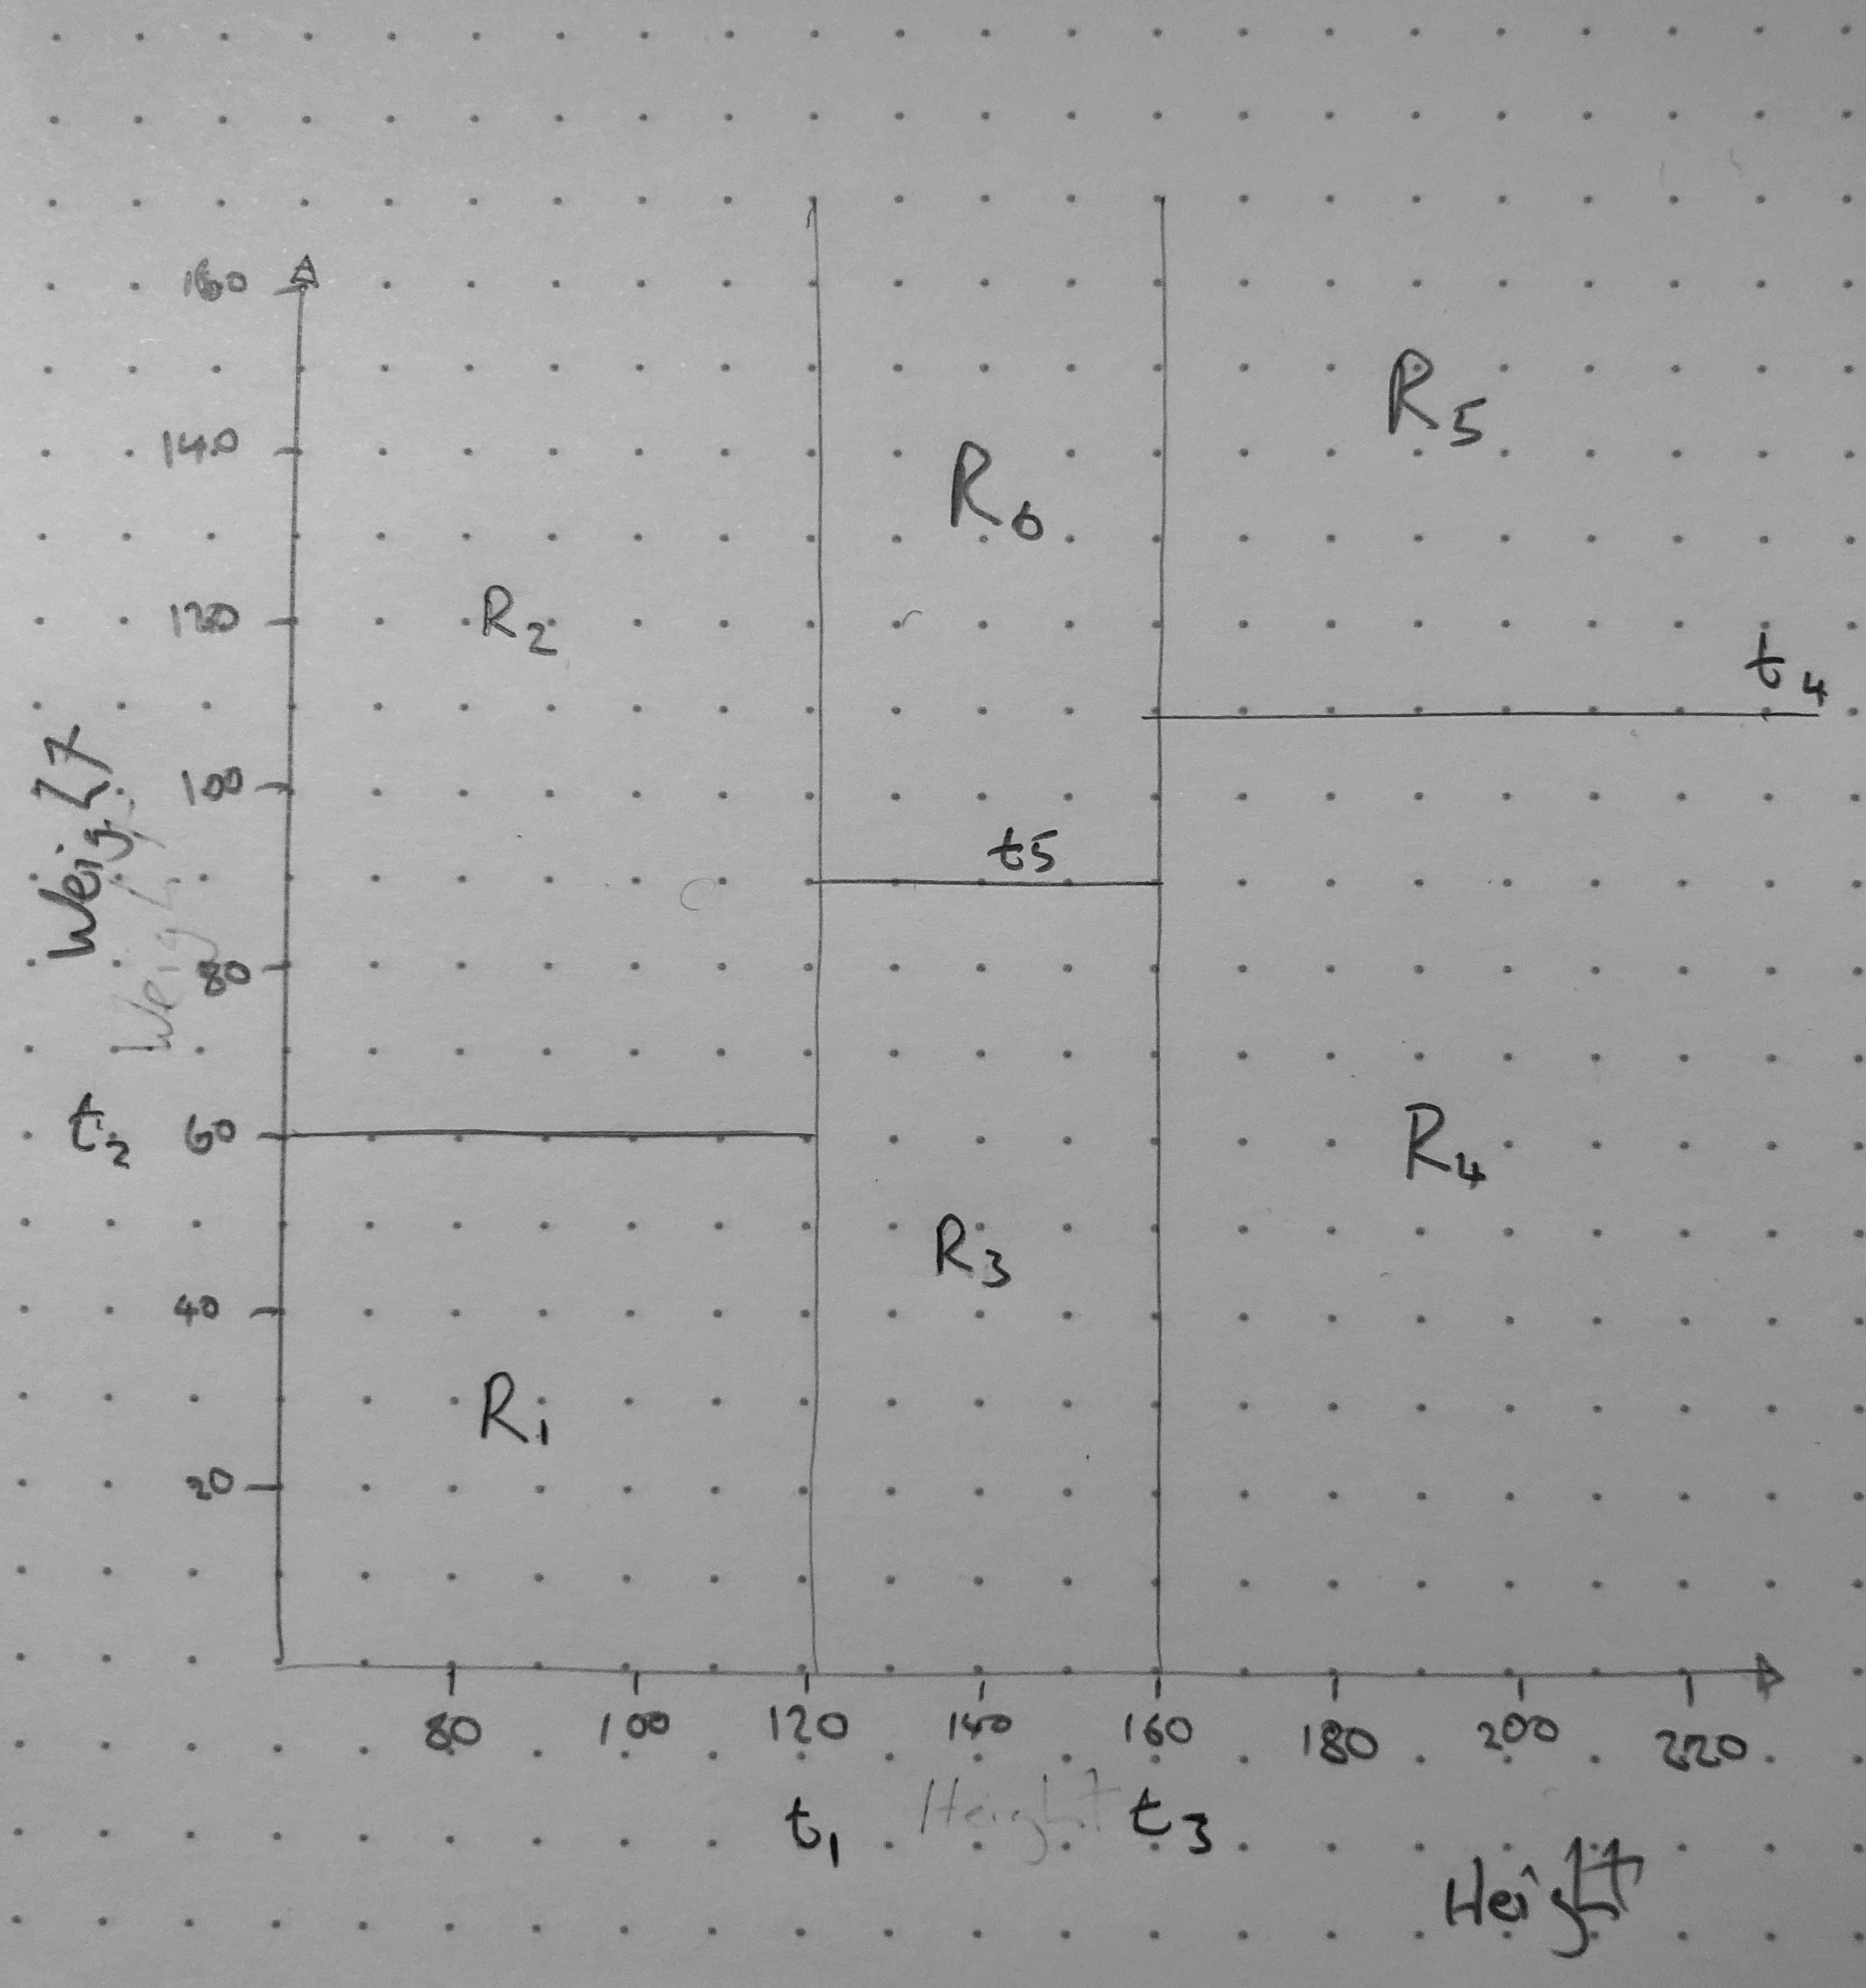

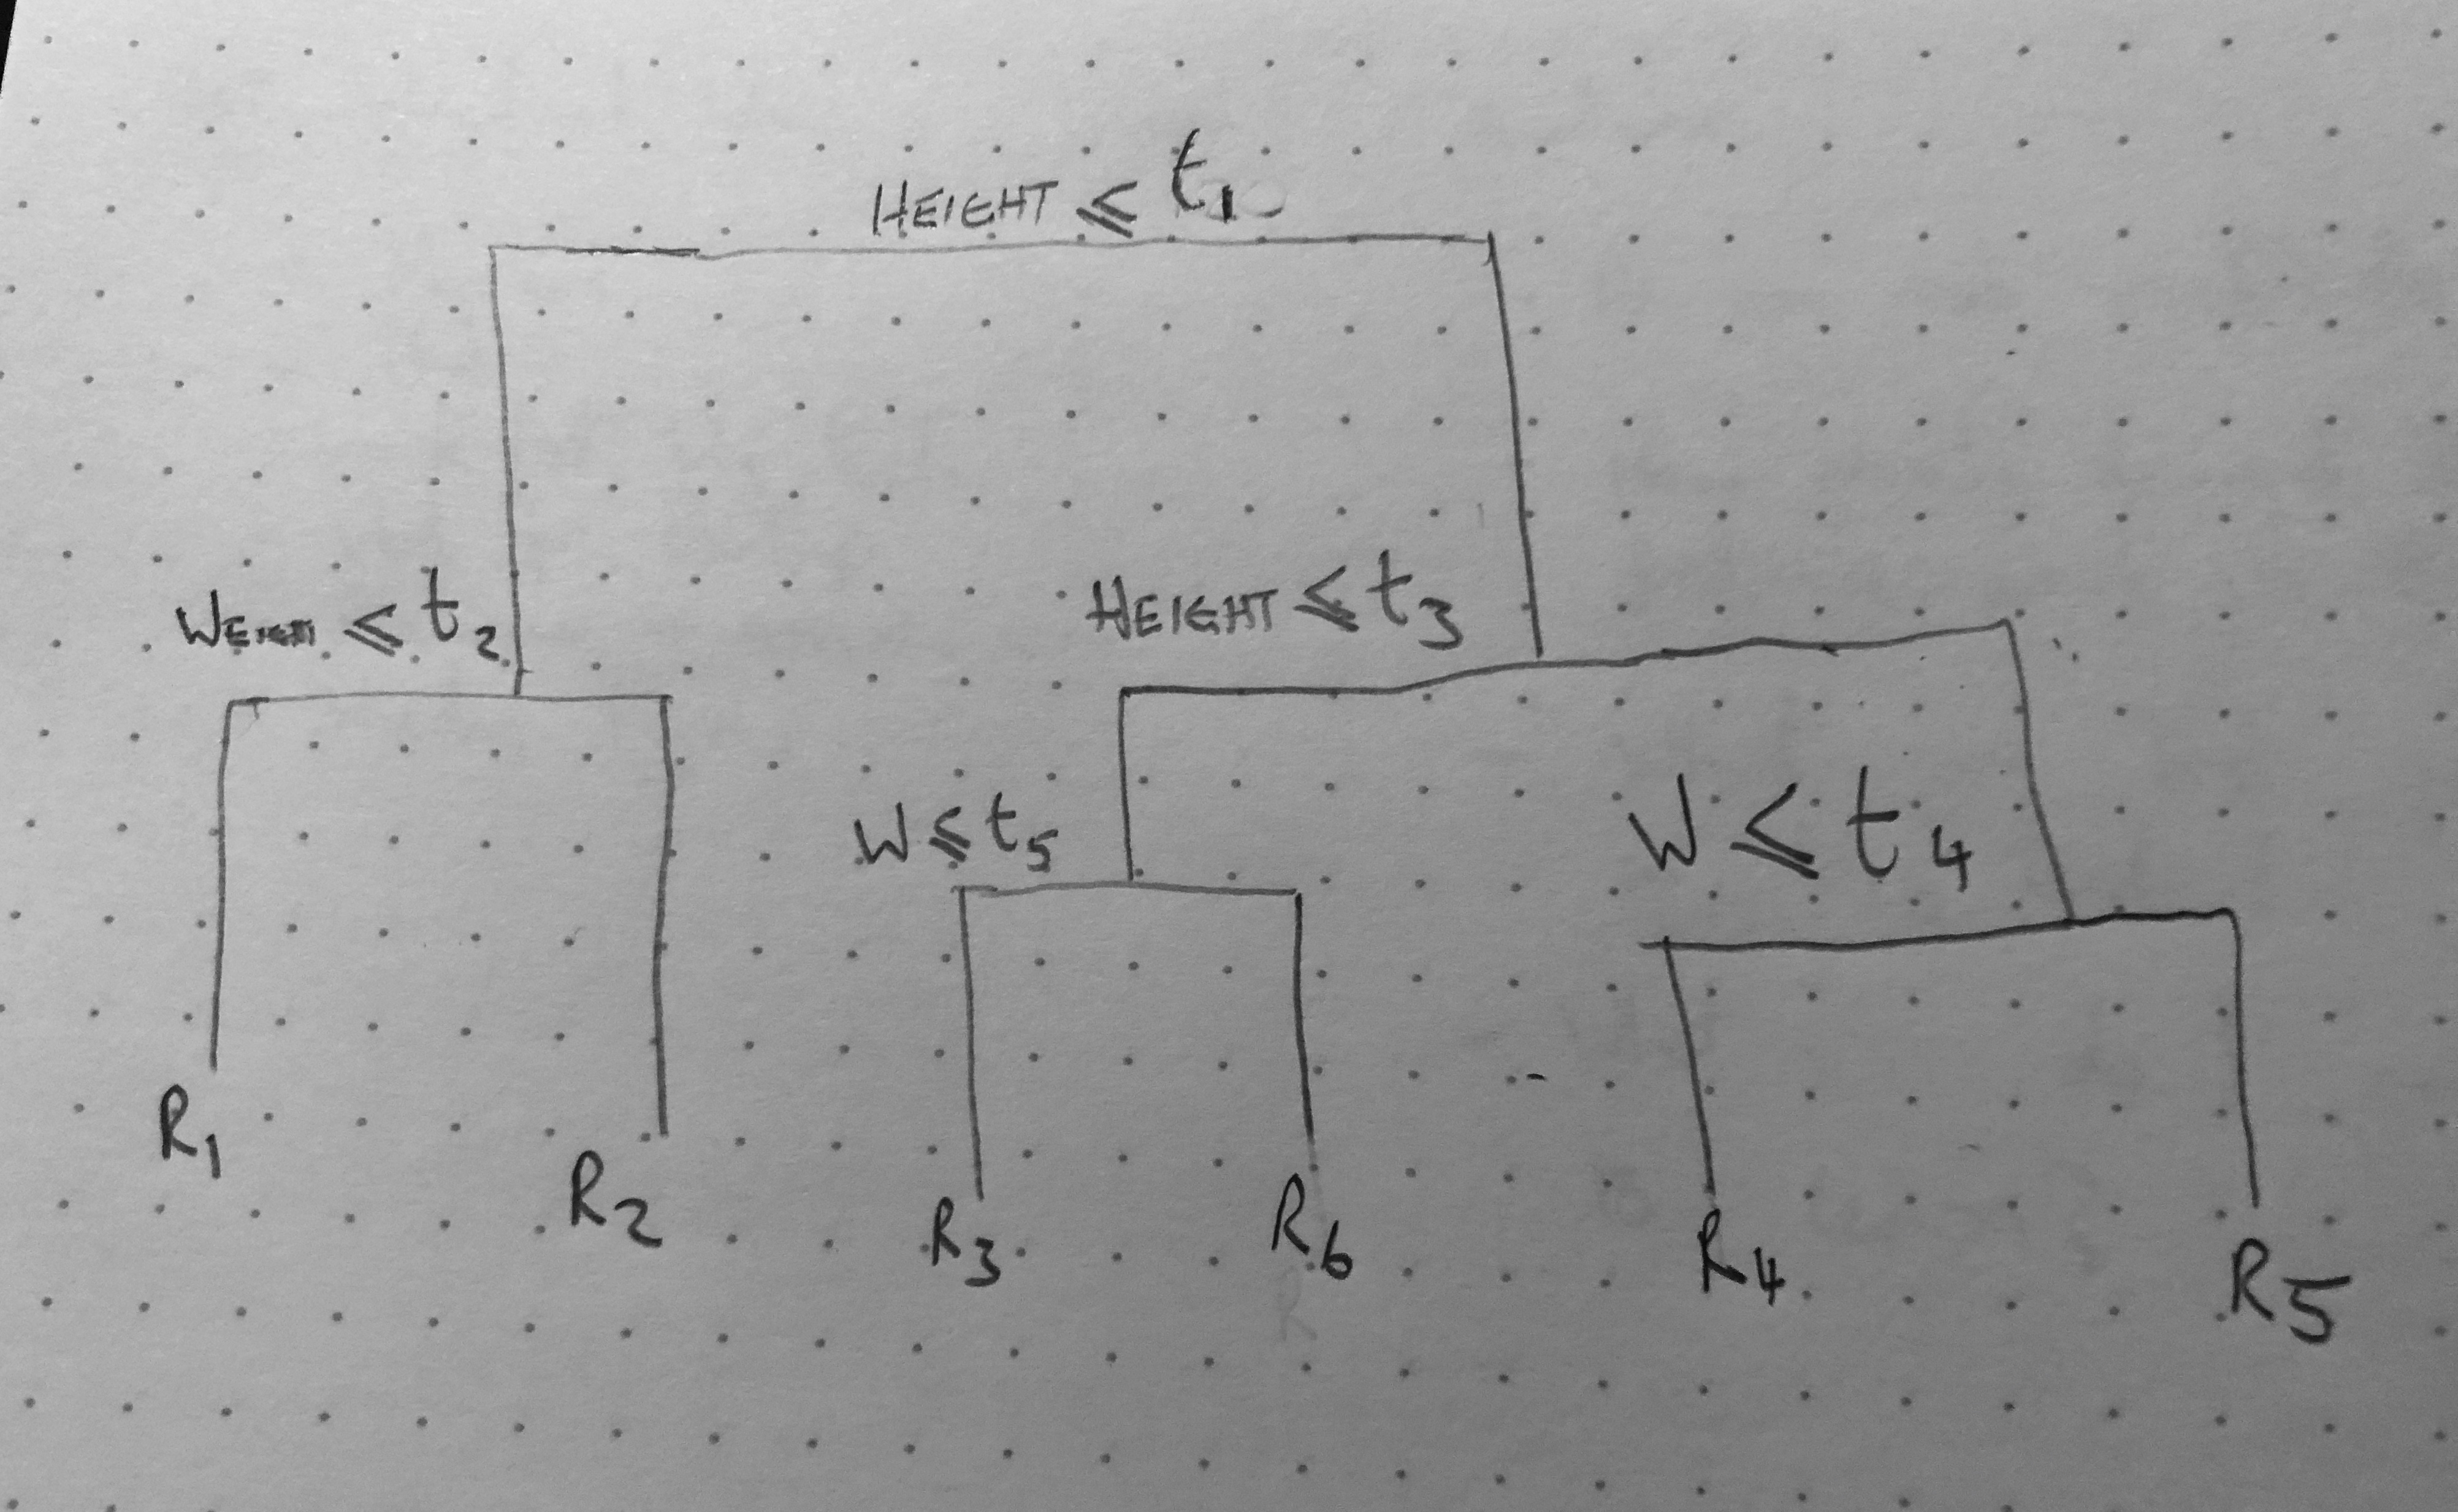

### 2. It is mentioned in Section 8.2.3 that boosting using depth-one trees (or stumps) leads to an additive model: that is, a model of the form

$$f(X) = \sum_{j=1}^{p}{f_j(X_j)}$$


### Explain why this is the case. You can begin with (8.12) in Algorithm 8.2.

A depth-one tree is a function of a single variable. In this setting the boosting algorithm becormes:

1. Set $\hat{f}(x) = 0$ and $r_i = y_i$ for all $i$ in training set
2. For $b = 1, 2, ..., B,$ repeat:
  - Fit a tree $\hat{f^b}$ with **1** split to the training data $(X, r)$
  - Update $\hat{f}$ by adding the new tree Note: it can't be shrunken because it is already as small as it can possibly be, also note that it is a function of a single feature

$$\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}^b(X_j)$$
  - Update the residuals,

$$r_i \leftarrow r_i - \hat{f}^b(x_j)$$

3. Output the boosted model,

$$\hat{f}(x) = \sum_{b=1}^{B}{\hat{f}^b(X_j)}$$

Because the model is constrained to using depth-one trees, each $\hat{f^b}$ generated in step 2 is a function of a single feature $\hat{f}^b(X_j)$ and so the model outputed in step 3 is a sum of functions of a given feature which can be thought of as an additive model. 

### 3. Consider the Gini index, classification error, and entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of pˆm1. The x- axis should display pˆm1, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy.

*Hint: In a setting with two classes, pˆm1 = 1 − pˆm2. You could make this plot by hand, but it will be much easier to make in R.*

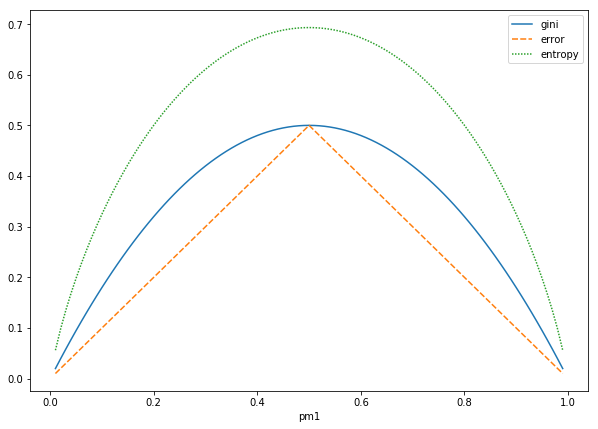

In [45]:
# pmk represent the proportion of training observations
# in the mth region that are from the kth class
# Here we consider two classes, K=2 for a given region m 
pm1 = np.arange(0.01, 1, 0.01)
gini = (pm1 * (1 - pm1)) + (pm2 * (1 - pm2))

# Classification error is the proportion of observations assigned to the wrong class
err=[]
for p in pm1:
    if 0.5 <= p:
        err += [1 - p]
    if p < 0.5:
        err += [p]

# Entropy
entropy = -((pm1 * np.log(pm1)) + (pm2 * np.log(pm2)))



# Plot against pm1
df = pd.DataFrame(np.stack([pm1, gini, err, entropy], axis=1), 
                  columns=['pm1', 'gini', 'error', 'entropy']).set_index('pm1')
plt.figure(figsize=(10, 7))
sns.lineplot(data=df);


## 4. This question relates to the plots in Figure 8.12.

### (a) Sketch the tree corresponding to the partition of the predictor space illustrated in the left-hand panel of Figure 8.12. The numbers inside the boxes indicate the mean of Y within each region.

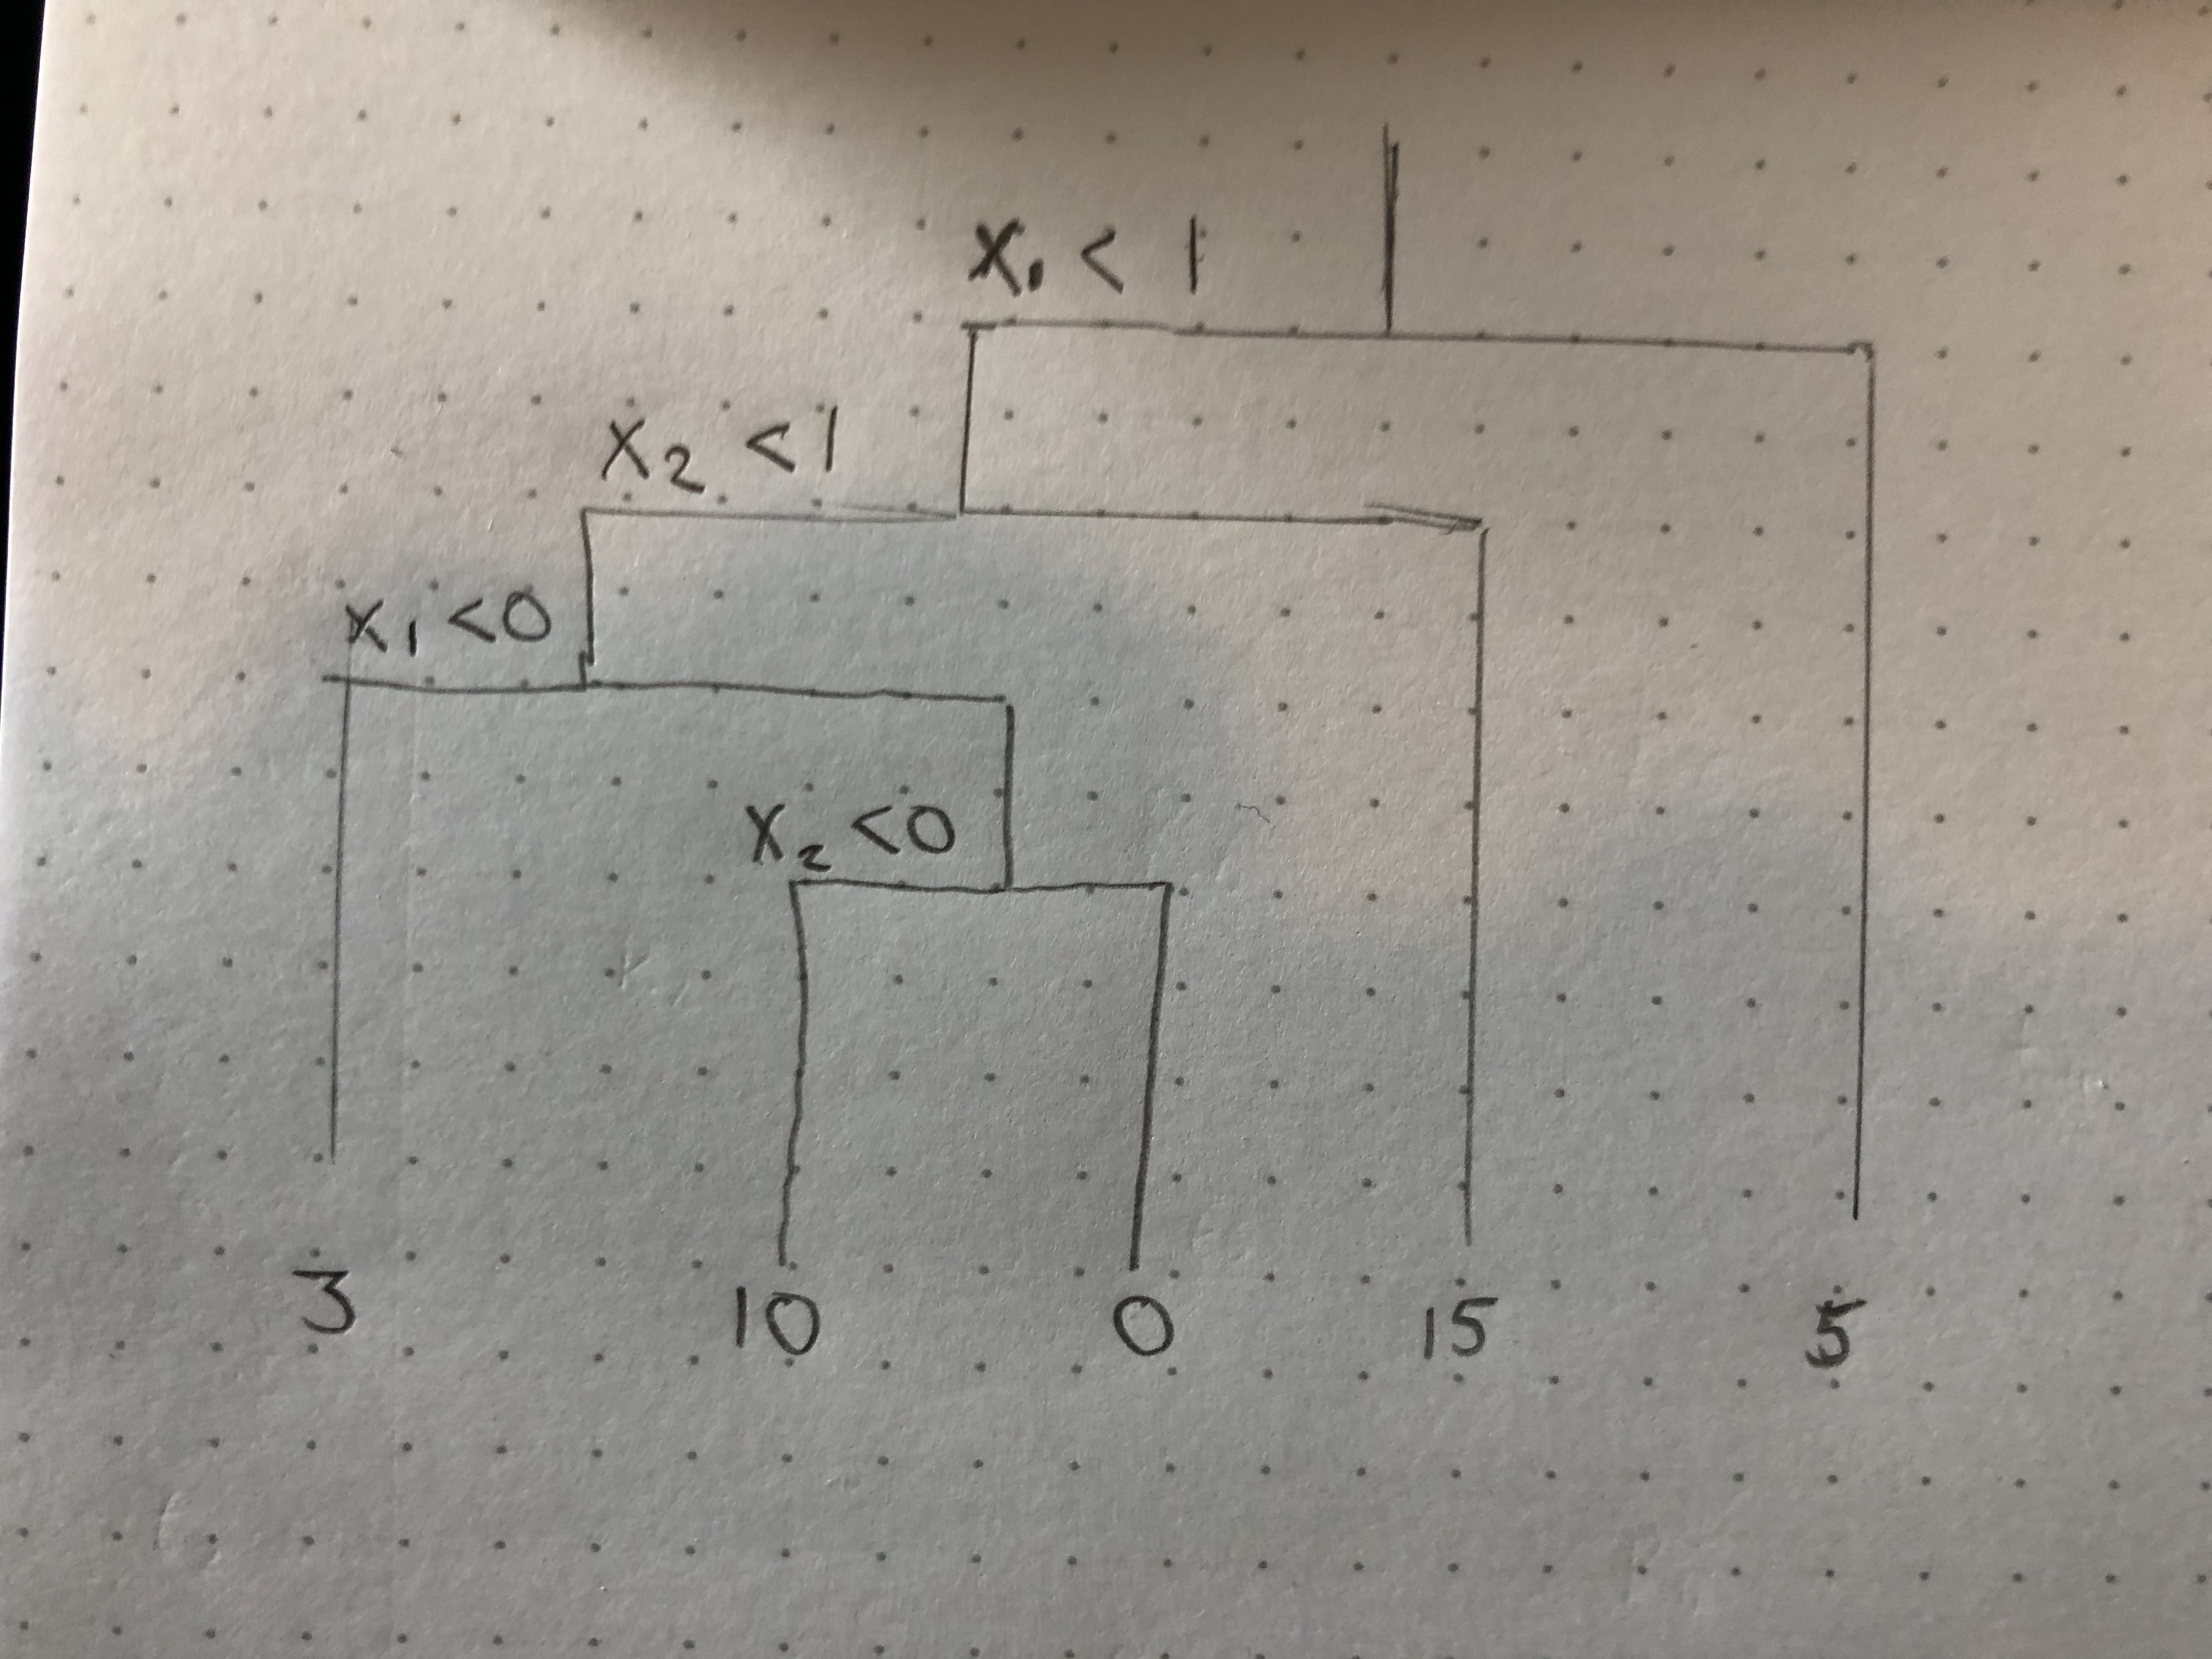

### (b) Create a diagram similar to the left-hand panel of Figure 8.12, using the tree illustrated in the right-hand panel of the same figure. You should divide up the predictor space into the correct regions, and indicate the mean for each region.

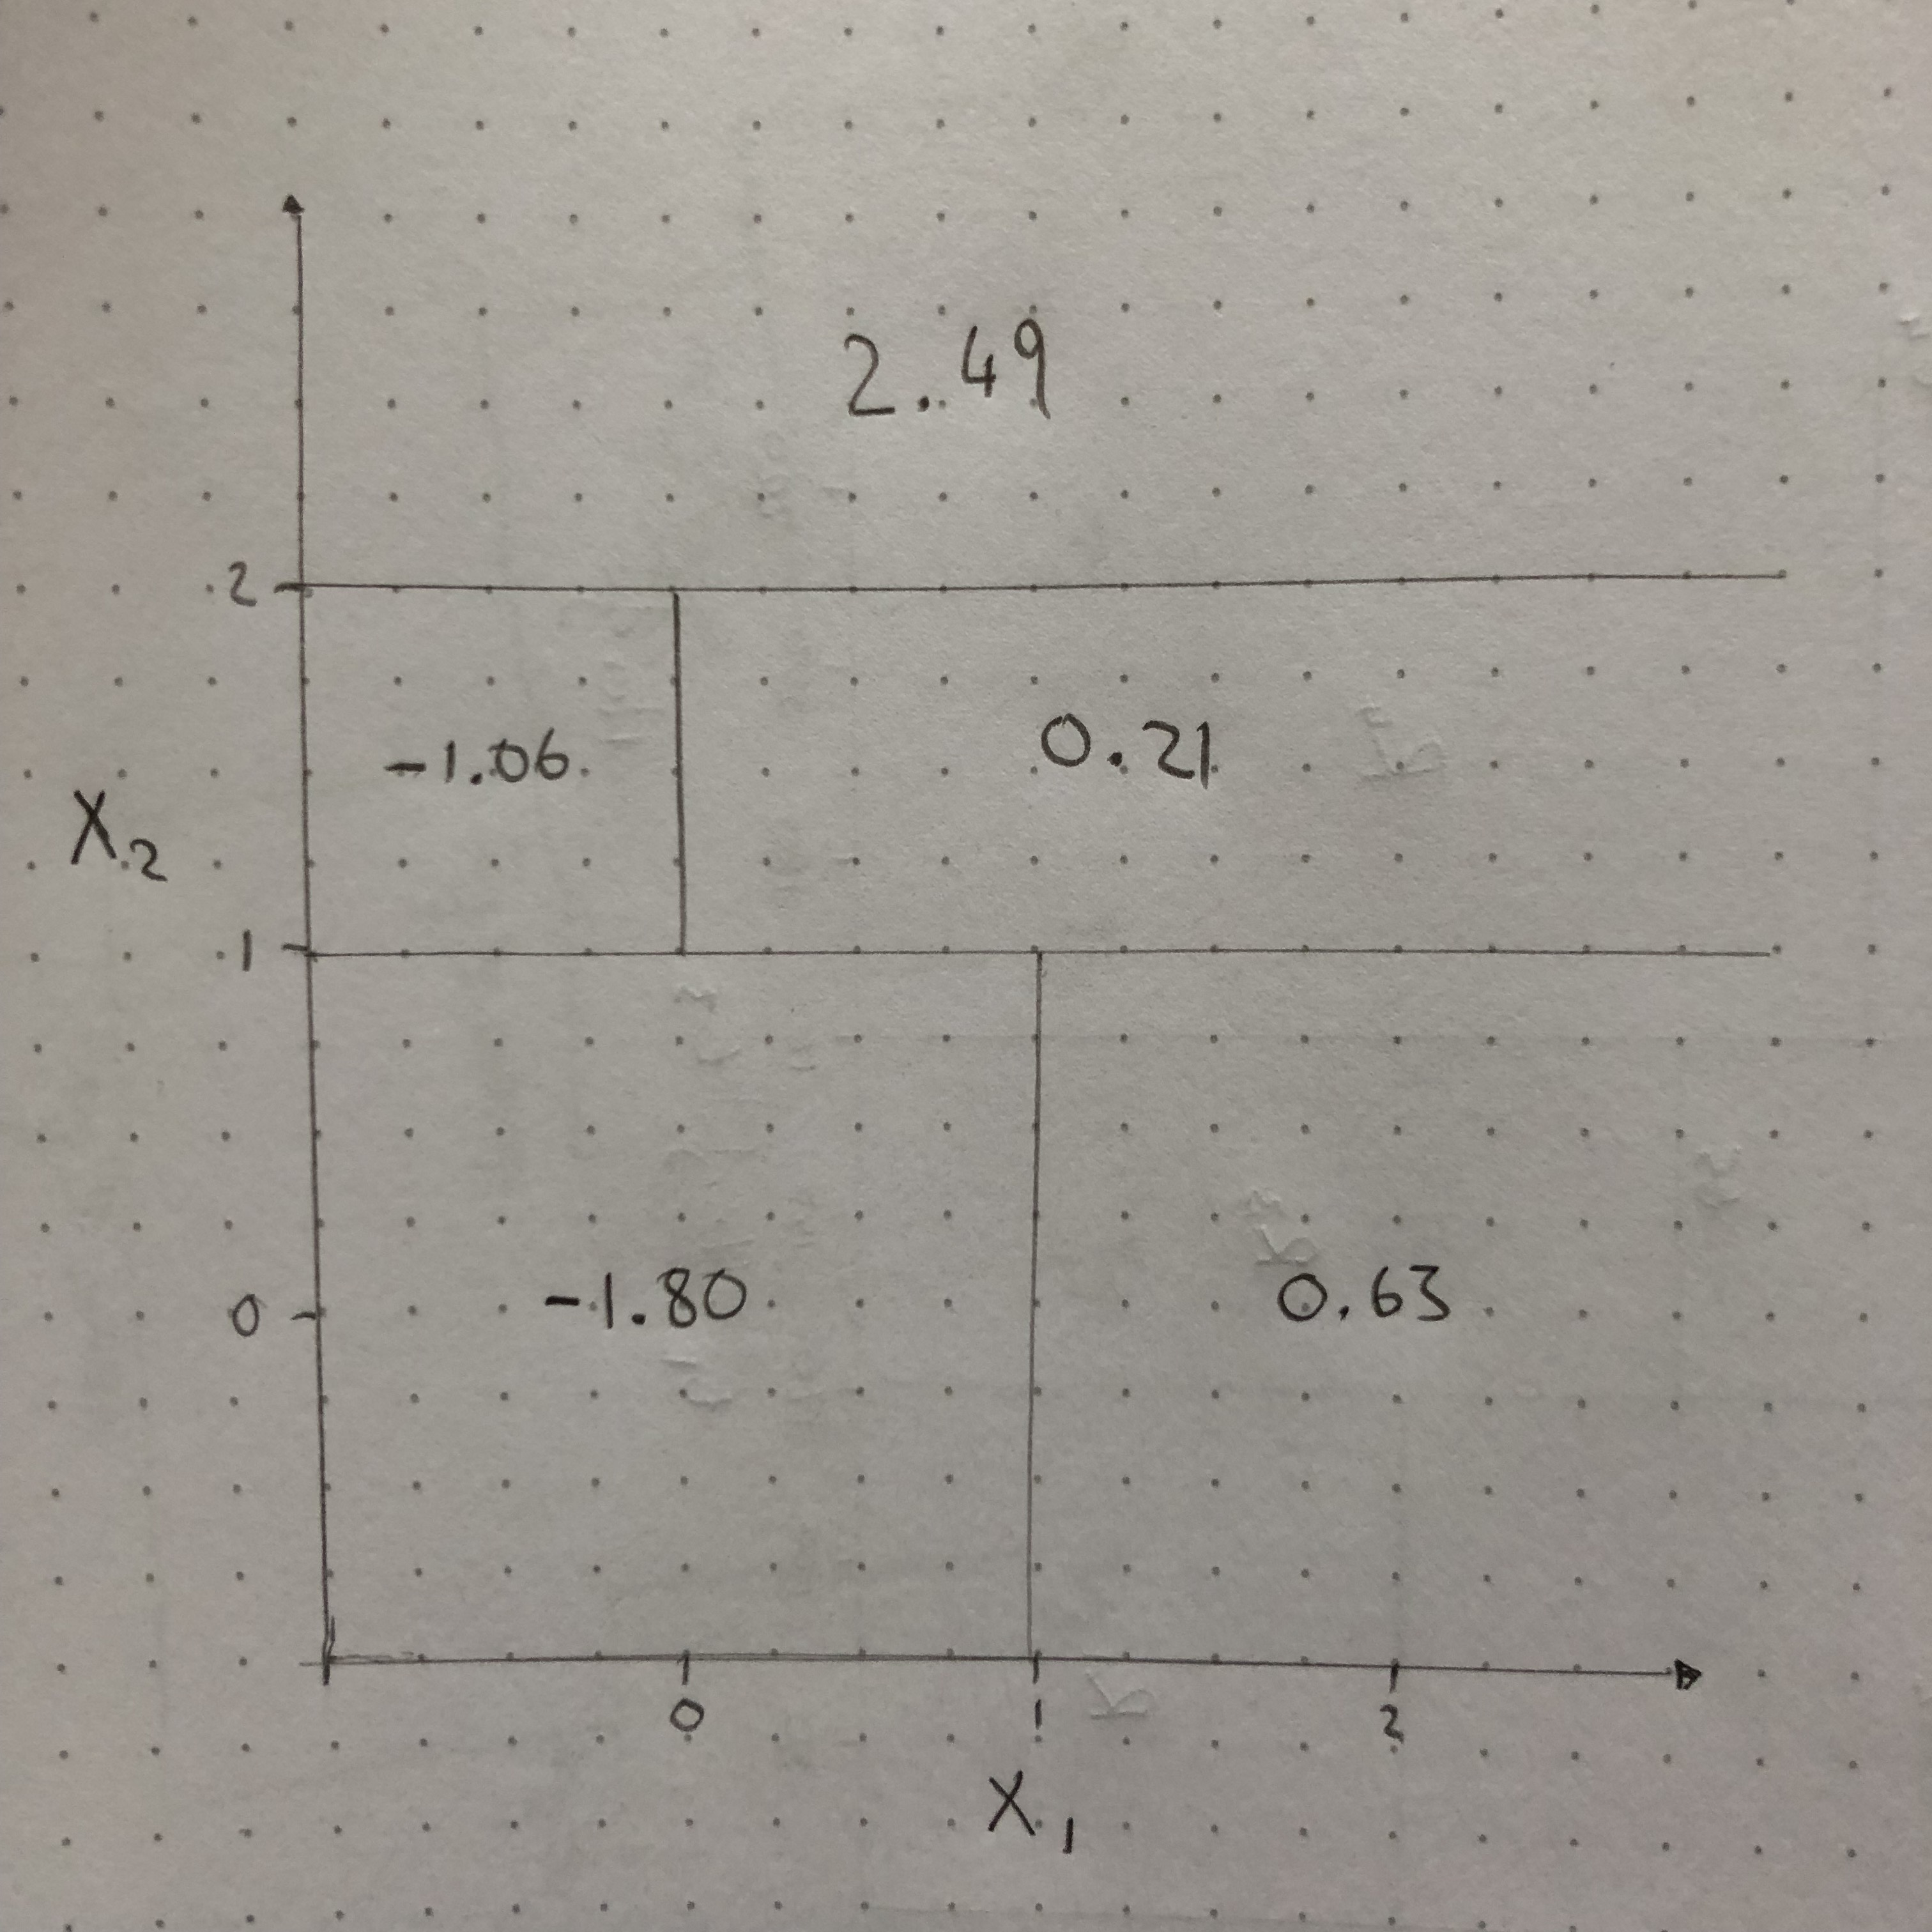

## 5. Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X):

$$0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and  0.75.$$

## There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?


In [61]:
x_isred_boot = np.array([0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7, 0.75])

def majority_clf(votes):
    pro_votes = (0.5 < votes).sum()
    majority_is_pro = (len(votes)/2) < pro_votes
    return majority_is_pro, pro_votes

def avg_clf(votes):
    avg = np.mean(votes)
    return (0.5 < avg, avg)

print('Is red (by Majority): {}, votes_red={}'.format(*majority_clf(x_isred_boot)))
print('Is red (by Average) : {}, avg={}'.format(*avg_clf(x_isred_boot)))


Is red (by Majority): True, votes_red=6
Is red (by Average) : False, avg=0.45


## 6. Provide a detailed explanation of the algorithm that is used to fit a regression tree.

#### Step 1: Recursive binary splitting

A decision tree divides the predictor space into $J$ distinct non-overlapping regions (see 4b above). But how do we decide where to place the splits?

One approach might be to consider all possible combinations of splits across all predictors, but this isn't likely to be tractable because the number of possible combinations of splits is extremely large for any moderately sized predictor space.

To get around this problem a top-down greedy approach is used called recursive binary splitting. This reduces the search space by only considering the optimal split at each step. Residual Sum of Squares (RSS) is used to measure optimality, at each step we search for a *single* additional split in predictor space that most reduces RSS. This process is repeated recursively with all sub regions of a all features considered at each step, with splits from previous steps being maintained (e.g. you can't split across a pre-existing split).

As this process is repeated through recursion an additional split and resultant region is added at each step. The regions at the bottom of the tree with no subsequent splits are called **leaf nodes** or **leaves**. The process is repeated until the population of observations in each leaf is less than some threshold $t$.

In the regression setting the estimated value for an observation that falls into a given leaf node, is the mean response value of all observations in that leaf.


#### Step 2: Cost complexity pruning

If the trheshold $t$ is small then the above step will result in a large complex tree that is optimised with respect to the training set. There will likely be some bias in the training set that is not representative of the true population, that the tree has accounted for, it has overfit the training data and this will impede its predictive power on new observations. 

One approach to mitigate overfitting might be to continue step one only so long ass the reduction in RSS at each step excedes some threshold. The problem with this is that some very valuable split might follow a low value split that doesn't exceed the threshold, in which case tree growth is halted prematurely. I'm not sure if this situation occurs often in practice, but the ISL authors suggest so.

Another approach is to grow a very large tree that overfits the training set, and then prune it back by removing splits. How to chose which splits to remove? 

This can be achieved by adding a penalty to RSS cost function that penalises a higher number of terminal nodes in the tree. RSS is given by:

$$\sum_{j=1}^{J}\sum_{i \in R_j}(y_i - \hat{y}_{R_j})^2$$

Adding a penalty for the number of terminal nodes $T$ is simple:


$$\sum_{j=1}^{J}\sum_{i \in R_j}(y_i - \hat{y}_{R_j})^2 + α|T|$$

Here α is the tuning parameter that controls the severity of the penalty, a small value of α around 0 will result in a large tree which decreases in size as α is increased.


#### Step 3: Choose α using cross-validation

We can now use cross-validation for some range of α to choose the optimal size tree. Each α results in a subtree of the full tree that we test using cross validation to estimate its test score. More generally this is an optimisaiton of the bias-variance tradeoff.


#### Step 4: Return subtree from Step 2 that corresponds to chosen value of α from Step 3

Finally we chose the subtree (value of α) that produces the best cross-validation score and use this for prediction.

